## Libraries

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import glob
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Loading Data

In [3]:
class ModelDataLoader:
    '''Loads and provides access to model input data and related information'''

    def __init__(self, version='000', extract_dir='/content/drive/MyDrive/'):
        self.version = version
        self.data_path = os.path.join(extract_dir, f'model_input_{self.version}')
        self.mfcc_path = os.path.join(extract_dir, f'model_input_{self.version}_mfcc')

        # Load the Parquet file
        self.df = pd.read_parquet(self.data_path)

        # Set up feature names and other data properties
        self.feature_names = ['spectral_centroids_mean',
                              'spectral_centroids_delta_mean',
                              'spectral_centroids_accelerate_mean',
                              'spectral_bandwidth_mean',
                              'spectral_rolloff_mean',
                              'zero_crossing_rate_mean',
                              'rms_mean',
                              'chroma_stft_mean',
                              'mfccs_mean',
                              'onset',
                              'tempo',
                              'contrast',
                              'tonnetz',
                              'mfccs_min',
                              'mfccs_max']
        self.label_names = self.df.label.unique()
        self.class_distribution = pd.DataFrame(self.df['label'].value_counts(normalize=True) * 100).reset_index()

        self.add_named_feature_columns()

    def add_named_feature_columns(self):
        for index, feature in enumerate(self.feature_names):
            self.df[feature] = self.df.features.map(lambda features: features[index] if features is not None else None)

    def get_mfcc(self):
        # Use the specified path for .npy files
        npy_files = glob.glob(os.path.join(self.mfcc_path, '*.npy'))

        mfcc_array = []
        for file in npy_files:
            mfcc_array.append(np.load(file, allow_pickle=True))

        # Concatenate arrays along the first axis
        combined_array = np.concatenate(mfcc_array, axis=0)
        return combined_array


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Initialize ModelDataLoader with the correct directory path
model_data_loader = ModelDataLoader(version='005')

# Access the loaded DataFrame
model_data_loader_df = model_data_loader.df
print("DataFrame loaded:")
display(model_data_loader_df.head())

# Load the MFCC features
features = model_data_loader.get_mfcc()
print("MFCC features loaded with shape:", features.shape)

DataFrame loaded:


,index,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708664,21.300203,0.022087,-505.499176,196.868652
1,2,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384018,21.096722,0.005648,-528.116272,209.443054
2,3,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,44100,...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.197205,229.155151
3,15,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.895813,199.950806
4,16,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185318,23.654802,-0.003315,-536.546936,222.208649


MFCC features loaded with shape: (24878,)


In [6]:
labels_series = model_data_loader.df['label']

In [7]:
feature_shapes = [feature.shape[1] for feature in features]
print("features shape distribution")
print(pd.Series(feature_shapes).value_counts())
print("total records: ", len(features))

features shape distribution
2582    13227
2585    10274
2812      522
1         472
1291      141
        ...  
2089        1
957         1
1175        1
1731        1
873         1
Name: count, Length: 106, dtype: int64
total records:  24878


In [8]:
# currently filtered to just the most common shapes, as we'll need to normalize shapes prior to training
MFCC_LENGTH_CUTOFF = 2582
#array of indexes matching a predicate
in_scope_feature_indexes = np.where(np.array(feature_shapes) >= MFCC_LENGTH_CUTOFF)[0]
print("normalized length: ",len(in_scope_feature_indexes))

normalized length:  24029


In [9]:
#pick subset of labels that are more intuitively representative of genre
#genres like pop which are ambiguous are removed
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
#optain the indexes of label series wher the label is in the list
in_scope_label_indexes = np.array(
    (labels_series[
                    labels_series
                        .apply(lambda x: True if x in  in_scope_labels else False)]
                        .index
    )
)

#combine filter for the in scope labels with the same for in scope features
in_scope_indexes = [index for index in in_scope_label_indexes if index in in_scope_feature_indexes]

print("Final Row count after filters: ", len(in_scope_indexes))

Final Row count after filters:  14912


In [10]:
in_scope_label_series = labels_series.iloc[in_scope_indexes]
unique_label_names = in_scope_label_series.unique()
unique_label_count = len(in_scope_label_series.unique())
label_to_int_map = {}
for index, label in enumerate(unique_label_names):
    label_to_int_map[label] = index

#numerical_labels = labels_series.map(label_to_int_map)
numerical_labels = in_scope_label_series.map(label_to_int_map)

encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(unique_label_names))

#put to list and reshape again
#not needed in current implementation
#encoded_labels_array = [label.reshape((unique_label_count,1)) for label in encoded_labels.numpy()]
print("Unique label count: ", unique_label_count)
print("label data count " , len(encoded_labels))

Unique label count:  8
label data count  14912


In [9]:
#truncate to consistent length while reshaping
reshaped_features = []
for feature in features[in_scope_indexes]:
    mfcc = []
    for vector in feature:
        mfcc.append(vector[0:MFCC_LENGTH_CUTOFF])
        mfcc_reshaped = np.array(mfcc)
    reshaped_features.append(mfcc_reshaped.reshape((MFCC_LENGTH_CUTOFF,13,1)))

## CNN Model

In [11]:
#generate train and test with stratification for equal label distribution across train and test
TEST_SIZE = .2
X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE, random_state=42, stratify =encoded_labels.numpy() )

In [12]:
#inspect shapes
X_train.shape, y_train.shape

((11929, 2582, 13, 1), (11929, 8))

In [13]:
model = keras.Sequential(layers=[
    #https://www.youtube.com/watch?v=dOG-HxpbMSw
    #convulution 1
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 2
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 3
    keras.layers.Conv2D(32, (2,2), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #flatten and feed into dense layer with dropiut
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.3),
    #predictions
    keras.layers.Dense(unique_label_count, activation=keras.activations.softmax)

    ])
cce = keras.losses.categorical_crossentropy

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

In [14]:
#note this currently only works after training
#To do figure out how to build model prior to training to inspect it's architectuer
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
#configuration
#BATCH_SIZE = 128
BATCH_SIZE = 64
#BATCH_SIZE = 32
EPOCHS = 50
EPOCHS = 6

Epoch 1/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.4215 - loss: 1.6069 - val_accuracy: 0.7850 - val_loss: 1.1974
Epoch 2/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.9442 - loss: 0.3024 - val_accuracy: 0.9878 - val_loss: 0.3136
Epoch 3/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.9911 - loss: 0.0821 - val_accuracy: 1.0000 - val_loss: 0.0325
Epoch 4/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.9965 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 5/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.9988 - loss: 0.0220 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 6/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.9987 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0013


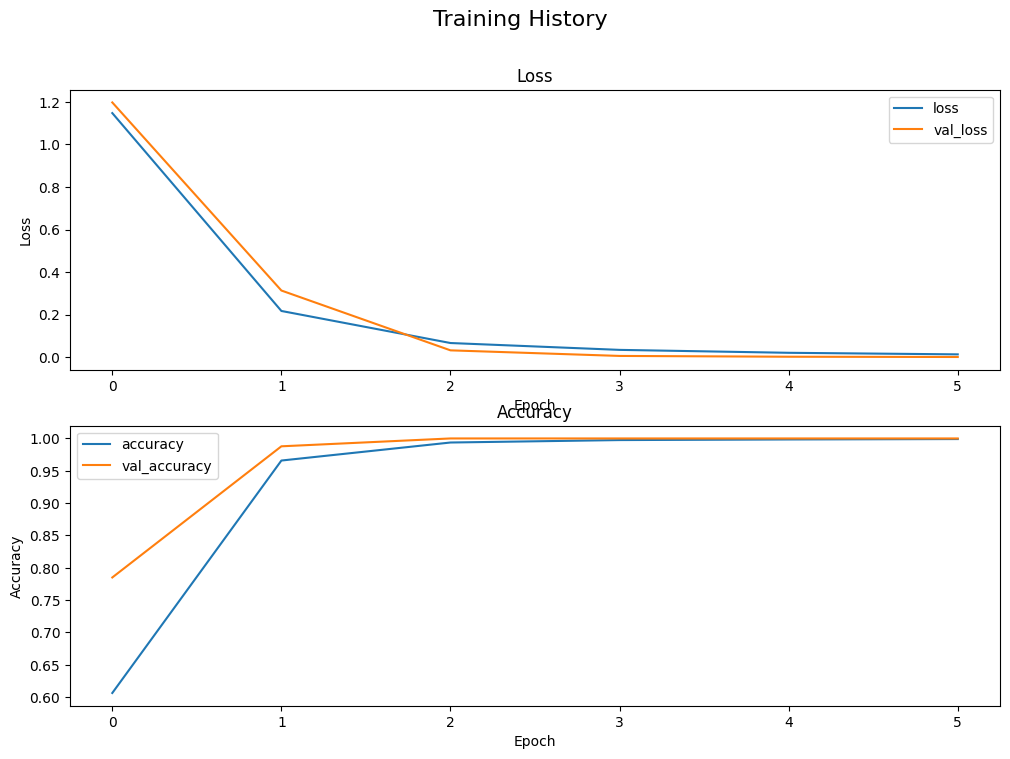

In [16]:
# Train the model
#following reference: https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification/notebook
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    #monitor='val_accuracy',
    min_delta = 0,
    patience=5,
    mode='auto',
    restore_best_weights=True
    )
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step


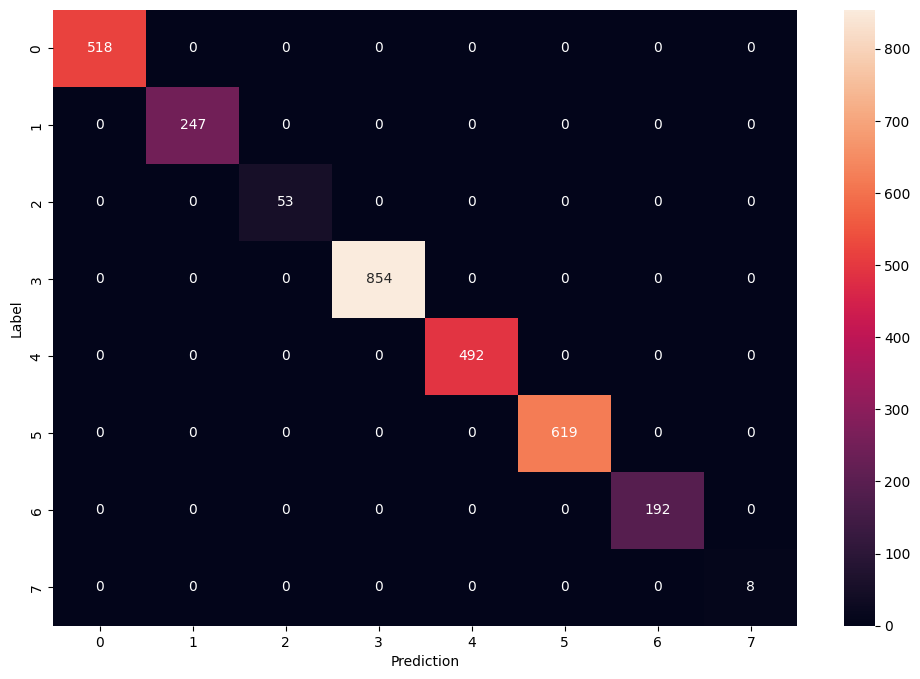

In [17]:
#validation
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(numerical_labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## CNN Layers Visualizations

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


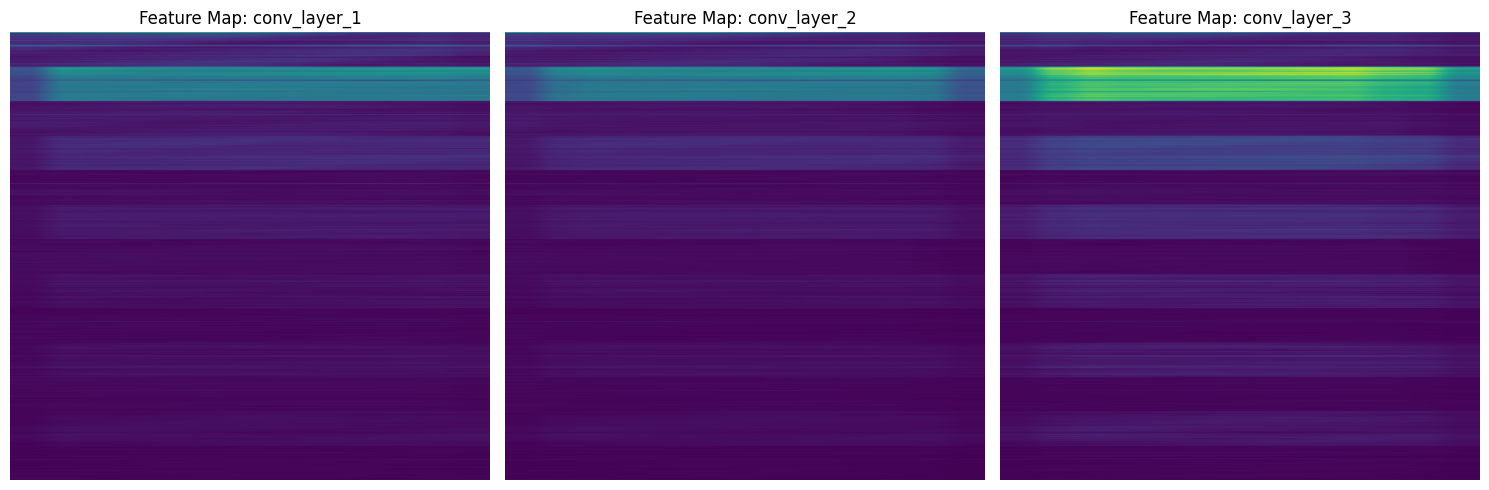

In [37]:
import tensorflow as tf
from tensorflow import keras
from skimage.transform import resize

# Define layer names to visualize
conv_layer_names = ["conv_layer_1", "conv_layer_2", "conv_layer_3"]

# Define the model without pooling layers
input_layer = keras.Input(shape=(2582, 13, 1))
x = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv_layer_1')(input_layer)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv_layer_2')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv_layer_3')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
output_layer = keras.layers.Dense(8, activation='softmax')(x)

# Define the full model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Dummy prediction to initialize model
model.predict(np.expand_dims(X_test[0], axis=0))

# Define a function to visualize feature maps without overlay
def visualize_feature_maps_without_overlay(model, input_data, layer_names):
    """
    Visualizes feature maps from specified layers without overlaying on MFCC.

    Parameters:
    - model: Trained CNN model.
    - input_data: Input sample for which feature maps are generated.
    - layer_names: List of layer names to visualize.

    Returns:
    - None (displays the feature maps directly).
    """
    # Create a model that outputs feature maps from the specified layers
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = tf.keras.Model(inputs=model.input, outputs=outputs)

    # Get feature maps for the input data
    feature_maps = activation_model.predict(np.expand_dims(input_data, axis=0))

    # Plot each feature map independently
    fig, axes = plt.subplots(1, len(layer_names), figsize=(15, 5))
    if len(layer_names) == 1:
        axes = [axes]

    for i, feature_map in enumerate(feature_maps):
        ax = axes[i]

        # Reduce feature map dimensions for visualization (average over channels)
        avg_feature_map = np.mean(feature_map[0], axis=-1)

        # Display the feature map
        ax.imshow(avg_feature_map, cmap='viridis', aspect='auto')
        ax.set_title(f'Feature Map: {layer_names[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Select a sample MFCC input from the test data
sample_index = 0
sample_input = X_test[sample_index]

# Visualize feature maps without overlay on MFCC heatmap
visualize_feature_maps_without_overlay(model, sample_input, conv_layer_names)

### Explanation of the CNN Feature Maps

The feature maps shown above represent the activations of the three convolutional layers in our CNN model. Here’s a breakdown of what each layer's feature map shows:

- **Feature Map: conv_layer_1**:
  - The first convolutional layer captures low-level features from the input MFCC data, such as edges or small variations in the audio signal across time frames.
  - We can see that there are slight variations in brightness in the top portion of the feature map, indicating areas of higher activation in response to certain patterns in the MFCC data.

- **Feature Map: conv_layer_2**:
  - The second layer builds upon the patterns detected in the first layer, identifying more complex features or combinations of low-level patterns.
  - The activations in this layer are somewhat more distinct than the first layer, suggesting that the model is starting to recognize broader structures in the audio data.

- **Feature Map: conv_layer_3**:
  - The third convolutional layer captures even more abstract patterns, focusing on higher-level features that may correlate with the underlying characteristics of the audio, such as timbre or rhythm.
  - This layer shows more intense activation in certain areas, which means it’s responding strongly to specific patterns or features in the input data.

Overall, each layer progressively abstracts the input MFCC data, with the final convolutional layer capturing high-level features that the model deems important for making predictions.

### Feature Maps Without Overlay

In this case, we visualized the feature maps without overlaying them on the original MFCC heatmap due to the inherent limitations of the MFCC’s structure:

1. **Narrow Frequency Dimension**:
   - The MFCC data has only 13 coefficients (frequency bins), making the input very narrow along the frequency axis. This limited frequency resolution means that the spatial information along the frequency dimension is not extensive enough to create visually meaningful overlays.
   - When we tried overlaying feature maps on the MFCC heatmap, the resulting images appeared narrow and compressed, making it difficult to interpret the patterns learned by each convolutional layer.

2. **Alternative Visualization for Better Interpretation**:
   - By visualizing the feature maps independently, we allowed each convolutional layer’s patterns to be displayed without constraints, providing a clearer view of what each layer has learned.
   - Displaying feature maps without overlay reveals how each layer responds to the input data without trying to align with the narrow frequency axis of the MFCCs, leading to more interpretable results.

In summary, due to the limited spatial resolution of the MFCC data along the frequency dimension, visualizing feature maps independently was a more effective way to understand the features being captured by each convolutional layer in the CNN model.


## CNN Model Prediction with Input Audio Files

In [56]:
# Define genre labels based on the subset used in training
genre_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country']

# Function to preprocess the audio file
def preprocess_audio(file_path, n_mfcc=13, max_pad_len=2582):
    """
    Loads an audio file, extracts MFCCs, and pads or truncates it to a fixed length.

    Parameters:
    - file_path: str, path to the audio file.
    - n_mfcc: int, number of MFCCs to extract.
    - max_pad_len: int, fixed length for the MFCC output (number of time frames).

    Returns:
    - mfcc: np.array, processed MFCCs of shape (max_pad_len, n_mfcc, 1).
    """
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to ensure fixed length
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    # Add a channel dimension to match the input shape expected by the CNN
    mfcc = np.expand_dims(mfcc, axis=-1)
    return mfcc

# Function to predict genre
def predict_genre(file_path):
    """
    Predicts the genre of an audio file using the CNN model.

    Parameters:
    - file_path: str, path to the audio file.

    Returns:
    - str, predicted genre label.
    """
    # Preprocess the audio file
    mfcc = preprocess_audio(file_path)

    # Add batch dimension
    mfcc = np.expand_dims(mfcc, axis=0)

    # Predict genre
    predictions = model.predict(mfcc)

    # Get the index of the highest probability
    predicted_index = np.argmax(predictions, axis=1)[0]

    # Map index to genre label
    predicted_genre = genre_labels[predicted_index]

    print(f"Predicted Genre for {file_path}: {predicted_genre}")
    return predicted_genre


In [57]:
# Define the directory containing the audio file (Electronic)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_electronic.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted Genre for /content/drive/MyDrive/sample_electronic.mp3: electronic


'electronic'

In [62]:
# Define the directory containing the audio file (Rap)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_rap.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Genre for /content/drive/MyDrive/sample_rap.mp3: country


'country'

In [61]:
# Define the directory containing the audio file (Rock)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_rock.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted Genre for /content/drive/MyDrive/sample_rock.mp3: electronic


'electronic'

In [63]:
# Define the directory containing the audio file (Classical)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_classical.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Genre for /content/drive/MyDrive/sample_classical.mp3: electronic


'electronic'

In [68]:
# Define the directory containing the audio file (Country)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_country.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Genre for /content/drive/MyDrive/sample_country.mp3: electronic


'electronic'

In [66]:
# Define the directory containing the audio file (Jazz)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_jazz.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted Genre for /content/drive/MyDrive/sample_jazz.mp3: electronic


'electronic'

In [73]:
# Define the directory containing the audio file (Country Acapella)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_country_acapella.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted Genre for /content/drive/MyDrive/sample_country_acapella.mp3: electronic


'electronic'

In [75]:
# Define the directory containing the audio file (Rap2)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_rap2.mp3')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicted Genre for /content/drive/MyDrive/sample_rap2.mp3: electronic


'electronic'

In [76]:
# Define the directory containing the audio file (Jazz GTZAN Data)
extract_dir = '/content/drive/MyDrive/'
audio_file_path = os.path.join(extract_dir, 'sample_jazz_gtzan.wav')

# Run prediction
predict_genre(audio_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predicted Genre for /content/drive/MyDrive/sample_jazz_gtzan.wav: electronic


'electronic'

### Report

#### Overview
This notebook focuses on building a Convolutional Neural Network (CNN) model to classify music genres based on Mel-frequency cepstral coefficients (MFCC) features. The project was developed using the following key steps:

1. **Data Preparation**:
   - Filtered the dataset to include only six genres: `rock`, `electronic`, `hiphop`, `classical`, `jazz`, and `country`.
   - Processed each audio file’s MFCC feature to ensure consistent length by truncating to 2582 frames and verifying 13 columns in each feature.
   - Applied one-hot encoding to labels for compatibility with the CNN model.

2. **Model Architecture**:
   - The CNN model was designed with multiple convolutional layers, batch normalization, dropout layers to reduce overfitting, and a final dense layer with softmax activation for multi-class classification.
   - Model hyperparameters, such as dropout rates and the number of filters, were set to maximize feature extraction while preventing overfitting.

3. **Model Training**:
   - Used early stopping to halt training if the validation loss did not improve after a set number of epochs, helping avoid overfitting.
   - Class weights were applied to address class imbalance, giving more weight to underrepresented genres.

#### Results
- **Training and Validation Performance**: The model achieved high accuracy on the training and validation sets, suggesting that it successfully learned to distinguish between the specified genres within the dataset.
- **Confusion Matrix Analysis**: Post-training evaluation with a confusion matrix showed high prediction accuracy for most genres in the test set. However, some genres, particularly minority classes like `country` and `jazz`, had more misclassifications.

#### Pain Points and Limitations
1. **Class Imbalance**:
   - Despite using class weights, the model still favored majority classes, notably `electronic` and `rock`, over less represented genres such as `country`. This led to over-representation of certain genres in the predictions.

2. **Real-World Generalization**:
   - When tested on real-world audio files, the model predominantly predicted the genre as `electronic`, indicating poor generalization beyond the training dataset. This limitation suggests that the model may have overfitted on the dataset's specific features rather than learning robust, generalized genre characteristics.

3. **Challenges with MFCC Features**:
   - MFCC features provide a good representation of short-term spectral information but may miss broader context information crucial for genre classification. This limitation could contribute to the model's over-reliance on certain spectral characteristics that are more prevalent in electronic music.

#### Recommendations
1. **Data Augmentation**: To improve model generalization, we could increase the diversity of training data by applying audio augmentations (e.g., pitch shifting, time-stretching).
2. **Additional Feature Extraction**: Consider incorporating features that capture broader temporal and harmonic information, such as chroma or rhythmic features, to help the model better differentiate genres.
3. **Experiment with Alternative Models**: A Recurrent Neural Network (RNN) or attention-based model may capture genre characteristics over time better than CNN, potentially improving real-world predictions.

#### Conclusion
The current CNN model performs well on the test set but struggles with real-world audio files, often predicting `electronic` as the default genre. This indicates that additional steps are needed to improve generalization, especially for genre diversity and real-world applicability. Moving forward, enhancing the dataset, exploring alternative architectures, and experimenting with additional features are recommended.
